This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import paragami

# BNP sensitivity libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.utils_lib as utils_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

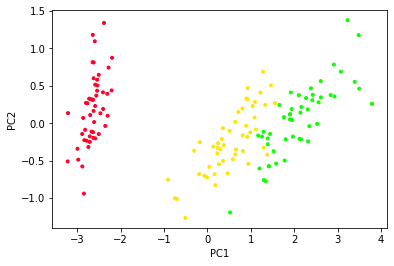

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

# set initial alpha
alpha0 = 3.5
prior_params_dict['alpha'] = alpha0
print(prior_params_dict)

{'alpha': 3.5, 'prior_centroid_mean': DeviceArray([0.], dtype=float64), 'prior_lambda': DeviceArray([1.], dtype=float64), 'prior_wishart_df': DeviceArray([10.], dtype=float64), 'prior_wishart_rate': DeviceArray([[1., 0., 0., 0.],
             [0., 1., 0., 0.],
             [0., 0., 1., 0.],
             [0., 0., 0., 1.]], dtype=float64)}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 15

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(iris_obs, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

DeviceArray(1703.77454659, dtype=float64)

# Optimize KL objective

### Initialize with K-means

In [9]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(iris_obs, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                  seed = 8901)

print('initial kl: ')
print(gmm_lib.get_kl(iris_obs, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
2228.365428785649


In [10]:
vb_params_dict = init_vb_params_dict

### Run CAVI

In [11]:
x_tol = 1e-3
vb_opt_dict, e_z_opt, _ = cavi_lib.run_cavi(iris_obs, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                            x_tol = x_tol)

Compiling CAVI update functions ... 
CAVI compile time: 3.79sec

Running CAVI ... 
done. num iterations = 128
stick_time: 1.93sec
cluster_time: 1.14sec
e_z_time: 0.608sec
**CAVI time: 5.56sec**


In [12]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

### Check results

In [13]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


### Plot centroids

Text(0, 0.5, 'PC2')

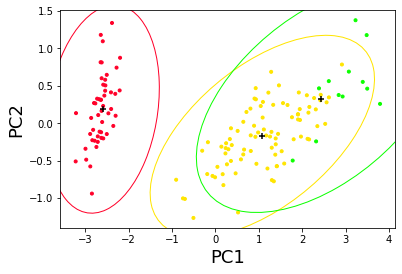

In [14]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [15]:
def get_e_num_obs_per_cluster(vb_params_dict): 
    ez = gmm_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_params_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
    return ez.sum(0)

In [16]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt_dict)
mixture_weights = gmm_lib.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)

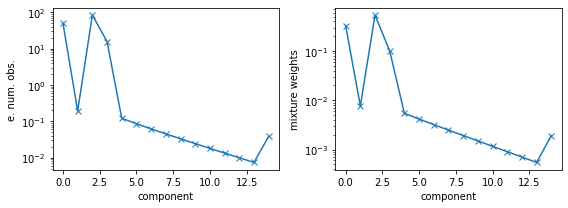

In [17]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

x = np.arange(k_approx)

axarr[0].semilogy(x, 
                  e_num_obs_per_cluster,
                  '-x')
axarr[0].set_ylabel('e. num. obs.')

axarr[1].semilogy(x, 
                  mixture_weights,
                  '-x')
axarr[1].set_ylabel('mixture weights')

for i in range(2): 
    axarr[i].set_xlabel('component')
    
fig.tight_layout()

# Parametric sensitivity

### Compute derivatives

In [18]:
use_free_alpha = True
hyper_param0 = prior_params_paragami['alpha'].flatten(prior_params_dict['alpha'],
                                                      free = use_free_alpha)

In [19]:
hyper_param0

DeviceArray([1.25276297], dtype=float64)

In [20]:
# set up objective as function of vb params and prior param 

def objective_fun(vb_params_dict, alpha): 
    
    _prior_params_dict = deepcopy(prior_params_dict)
    _prior_params_dict['alpha'] = alpha
    
    return gmm_lib.get_kl(iris_obs, vb_params_dict, _prior_params_dict,
                    gh_loc, gh_weights).squeeze()


objective_fun_free = paragami.FlattenFunctionInput(
                                original_fun=objective_fun, 
                                patterns = [vb_params_paragami, prior_params_paragami['alpha']],
                                free = [True, use_free_alpha],
                                argnums = [0, 1])

In [21]:
vb_sens = HyperparameterSensitivityLinearApproximation(objective_fun_free,
                                                        vb_opt,
                                                        hyper_param0)

Compiling hessian solver ...
Hessian solver compile time: 67.059sec

Compiling cross hessian...
Cross-hessian compile time: 1.01487sec

LR sensitivity time: 0.0444989sec



In [22]:
# double check the timing ... 

# cross hessian time
cross_hess = vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value, vb_sens.hyper_par_value0).block_until_ready()
%timeit vb_sens.dobj_dhyper_dinput(vb_sens.opt_par_value, vb_sens.hyper_par_value0).block_until_ready()

305 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
# solver time
%timeit vb_sens.hessian_solver(cross_hess.squeeze()).block_until_ready()

17.7 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Fit for a range of alpha

In [24]:
alpha_list = np.arange(1, 15)

In [25]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    vb_pert_dict = cavi_lib.run_cavi(iris_obs, deepcopy(new_init_dict),
                                     vb_params_paragami, prior_params_pert_dict,
                                     gh_loc, gh_weights,
                                     debug = False)[0]

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert

In [26]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [27]:
refit_list = []

new_init_dict = deepcopy(vb_opt_dict)

for alpha in alpha_list: 
    print('\n################')
    print('re-optimzing with alpha = ', alpha)
    print('################')
    
    refit_list.append(refit_with_alpha(alpha, new_init_dict))


################
re-optimzing with alpha =  1
################
Compiling CAVI update functions ... 
CAVI compile time: 3.13sec

Running CAVI ... 
done. num iterations = 93
stick_time: 1.36sec
cluster_time: 1.1sec
e_z_time: 0.0377sec
**CAVI time: 2.63sec**

################
re-optimzing with alpha =  2
################
Compiling CAVI update functions ... 
CAVI compile time: 2.9sec

Running CAVI ... 
done. num iterations = 59
stick_time: 0.796sec
cluster_time: 0.0586sec
e_z_time: 0.024sec
**CAVI time: 0.957sec**

################
re-optimzing with alpha =  3
################
Compiling CAVI update functions ... 
CAVI compile time: 2.75sec

Running CAVI ... 
done. num iterations = 36
stick_time: 0.486sec
cluster_time: 0.036sec
e_z_time: 0.0155sec
**CAVI time: 0.587sec**

################
re-optimzing with alpha =  4
################
Compiling CAVI update functions ... 
CAVI compile time: 2.89sec

Running CAVI ... 
done. num iterations = 43
stick_time: 0.609sec
cluster_time: 0.0431sec
e_z_

### Get linear response for each alpha

In [28]:
lr_list = []

for alpha in alpha_list: 
    
    hyper_param_pert = prior_params_paragami['alpha'].flatten(alpha, free = use_free_alpha)
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(hyper_param_pert))

### Print results

In [29]:
def print_diff_plot(lr_vb_free_params, 
                    vb_opt_pert,
                    vb_opt,
                    ax, 
                    alpha = 1):
    
    ax.scatter(lr_vb_free_params - vb_opt, 
                vb_opt_pert - vb_opt, 
                marker = 'o', 
                color = 'red', 
                alpha = alpha)

    ax.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', 
             color = 'blue')

    ax.set_xlabel('lr')
    ax.set_ylabel('refit')

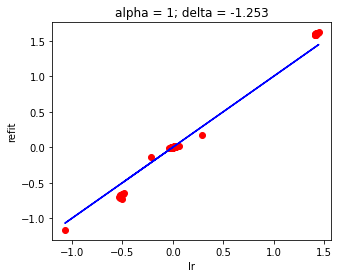

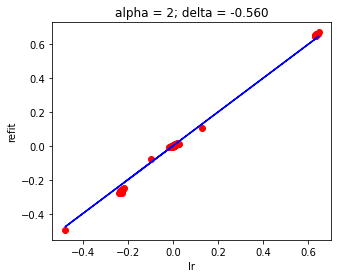

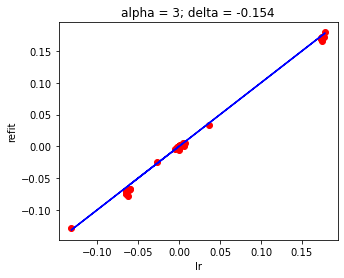

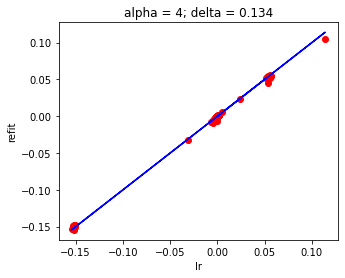

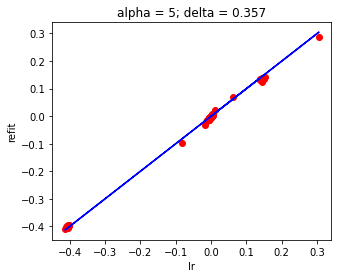

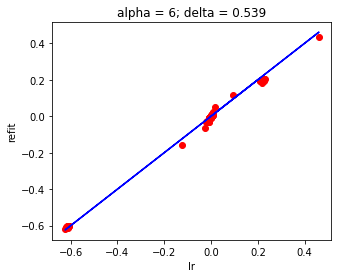

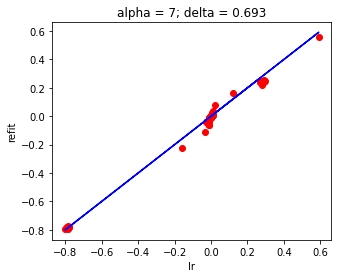

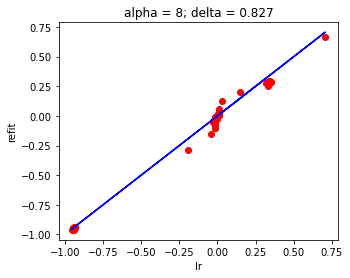

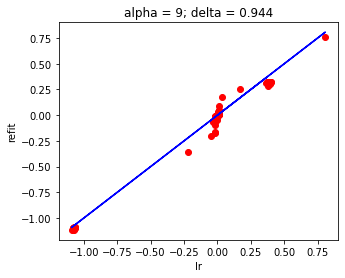

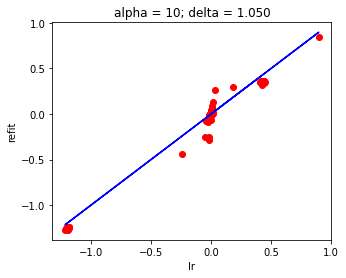

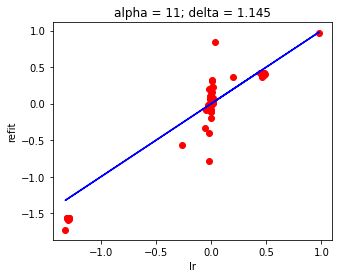

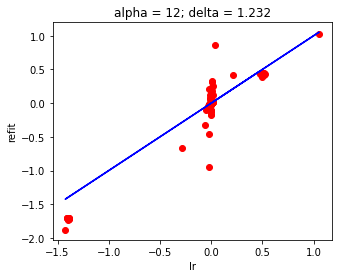

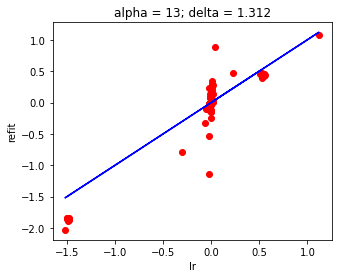

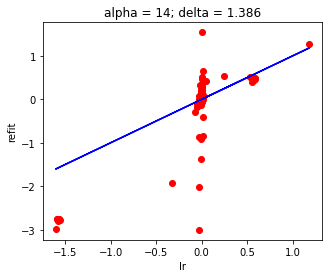

In [30]:
for i in range(len(alpha_list)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    print_diff_plot(lr_list[i], refit_list[i], vb_opt, ax)
    
    alpha = alpha_list[i]
    hyper_param_pert = prior_params_paragami['alpha'].flatten(alpha,
                                                              free = use_free_alpha)
    delta = hyper_param_pert - hyper_param0
    plt.title('alpha = ' + str(alpha) + '; delta = {:.03f}'.format(delta[0]))
    

# Check results on number of clusters

### results on number of in-sample clusters

In [31]:
refit_color = '#d95f02'
lr_color = '#1b9e77'

In [32]:
import numpy as onp

In [33]:
prng_key = jax.random.PRNGKey(223)
threshold = 0

@jax.jit
def get_n_clusters_insample(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_lib.get_e_num_clusters_from_vb_dict(iris_obs,
                                                    vb_params_dict,
                                                    gh_loc, gh_weights,
                                                    threshold = threshold,
                                                    n_samples = 10000, 
                                                    prng_key = prng_key)

@jax.jit
def get_n_clusters_pred(vb_free):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return gmm_lib.get_e_num_pred_clusters_from_vb_dict(vb_params_dict,
                                                               n_obs = iris_obs.shape[0],
                                                               threshold = threshold,
                                                               prng_key = prng_key)

In [34]:
def print_trace_plot(g, ax): 
    lr_vec = onp.zeros(len(refit_list))
    refit_vec = onp.zeros(len(refit_list))
    
    for i in range(len(refit_list)): 
        lr_vec[i] = g(lr_list[i])
        refit_vec[i] = g(refit_list[i])
    
    # plot lr
    ax.plot(alpha_list, 
            lr_vec, 
            'o-',
            color = lr_color,
            label = 'lr')
    
    # plot refit
    ax.plot(alpha_list,
            refit_vec, 
            'o-',
            color = refit_color,
            label = 'refit')

    ax.set_xlabel('alpha')
    
    ax.axvline(alpha0, color = 'red', linestyle = 'dashed')

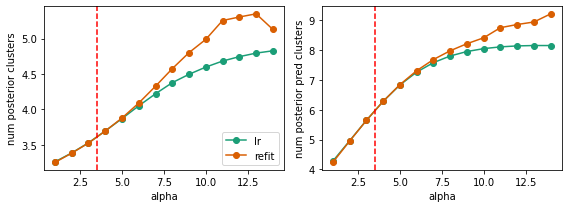

In [35]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

# in sample number of clusters
print_trace_plot(get_n_clusters_insample, axarr[0])
axarr[0].set_ylabel('num posterior clusters')
axarr[0].legend()

# predictive number of clusters
print_trace_plot(get_n_clusters_pred, axarr[1])
axarr[1].set_ylabel('num posterior pred clusters')

fig.tight_layout()

# Some other posterior quantities

### Coclustering

In [36]:
import scipy.cluster.hierarchy as sch

In [37]:
# for better plotting, cluster the ez's
link = sch.linkage(e_z_opt, method='average')
indx = sch.dendrogram(link, no_plot=True)["leaves"]

In [38]:
@jax.jit
def get_coclustering(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, 
                                             free = True)
    
    ez = gmm_lib.get_optimal_z_from_vb_dict(iris_obs,
                                            vb_params_dict,
                                            gh_loc,
                                            gh_weights,
                                            use_bnp_prior = True)[indx]
    
    return np.dot(ez, ez.transpose())

In [39]:
def get_coclust_mean_abs_diff(vb_params_free): 
    init_coclust = get_coclustering(vb_opt)
    pert_coclust = get_coclustering(vb_params_free) 
    
    return np.abs(pert_coclust - init_coclust).mean()

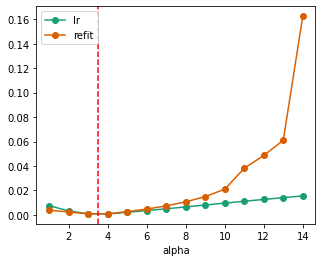

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))

print_trace_plot(get_coclust_mean_abs_diff, ax)
ax.legend()

In [58]:
# pick a particular alpha
alpha_pert = 8
alpha_indx = np.argwhere(alpha_list == alpha_pert).squeeze()

In [59]:
coclust_init = get_coclustering(vb_opt)
coclust_lr = get_coclustering(lr_list[alpha_indx])
coclust_refit = get_coclustering(refit_list[alpha_indx])

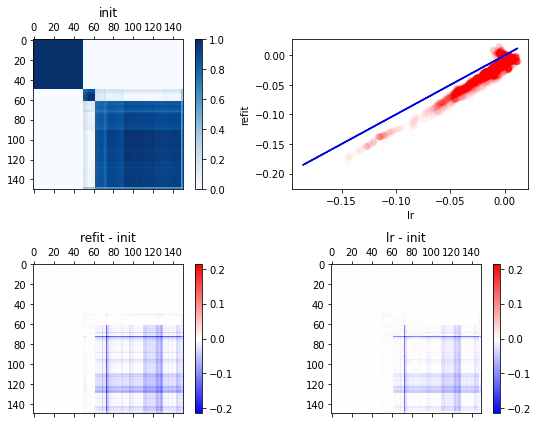

In [60]:
fig, axarr = plt.subplots(2, 2, figsize = (8, 6))

im0 = axarr[0, 0].matshow(coclust_init, 
                 cmap = plt.get_cmap('Blues'))
axarr[0, 0].set_title('init')
fig.colorbar(im0, ax = axarr[0, 0])

print_diff_plot(coclust_lr.flatten(), 
                coclust_refit.flatten(),
                coclust_init.flatten(), 
                axarr[0, 1], 
                alpha = 0.01)


diff_refit = coclust_refit - coclust_init
diff_lr = coclust_lr - coclust_init
vmax = max(np.abs(diff_refit).max(), np.abs(diff_lr).max())

# plot diff in refit
im1 = axarr[1, 0].matshow(diff_refit, 
                       cmap = plt.get_cmap('bwr'), 
                       vmax = vmax, vmin = -vmax)
fig.colorbar(im1, ax = axarr[1, 0])
axarr[1, 0].set_title('refit - init')

# plot diff in lr
im2 = axarr[1, 1].matshow(diff_lr, 
                       cmap = plt.get_cmap('bwr'), 
                       vmax = vmax, vmin = -vmax)
fig.colorbar(im2, ax = axarr[1, 1])
axarr[1, 1].set_title('lr - init')

fig.tight_layout()

### Mixture weights

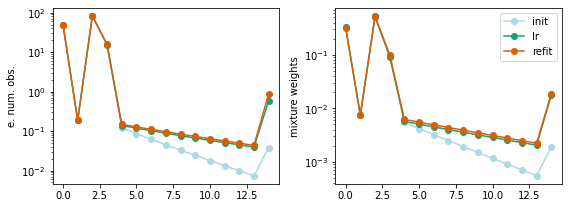

In [47]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

def plot_mixture_weights(vb_free, color, label = ''): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_params_dict)
    mixture_weights = gmm_lib.get_e_mixture_weights_from_vb_dict(vb_params_dict, gh_loc, gh_weights)
    
    x = np.arange(k_approx)
    
    axarr[0].semilogy(x, 
                      e_num_obs_per_cluster,
                      '-o', 
                      color = color, 
                      label = label)
    axarr[0].set_ylabel('e. num. obs.')

    axarr[1].semilogy(x, 
                      mixture_weights,
                      '-o', 
                      color = color, 
                      label = label)
    axarr[1].set_ylabel('mixture weights')
    axarr[1].legend()


plot_mixture_weights(vb_opt, color = 'lightblue', label = 'init')
plot_mixture_weights(lr_list[alpha_indx], color = lr_color, label = 'lr')
plot_mixture_weights(refit_list[alpha_indx], color = refit_color, label = 'refit')


fig.tight_layout()

In [48]:
# its slow if not jitted
_get_mixture_weights = jax.jit(gmm_lib.get_e_mixture_weights_from_vb_dict)

def get_mixture_weights_k(vb_free, k):
    
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    mixture_weights = _get_mixture_weights(vb_params_dict, gh_loc, gh_weights)
    
    return mixture_weights[k]

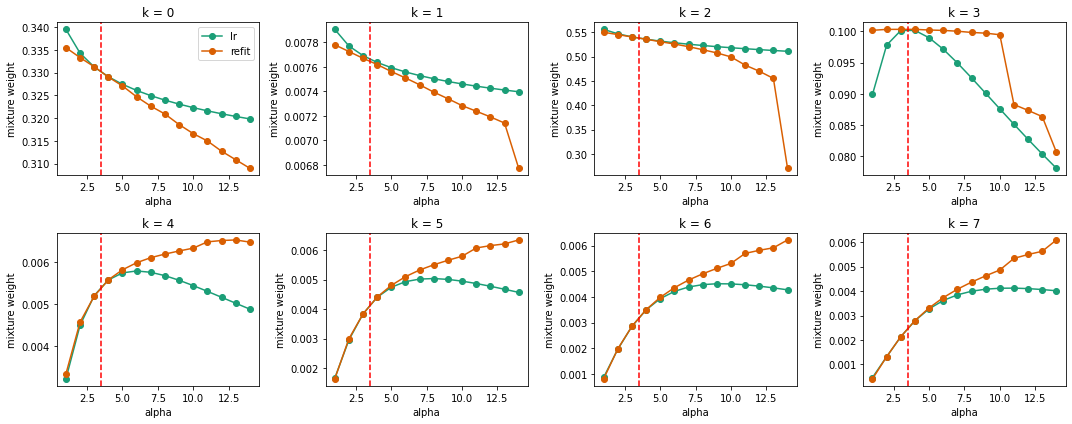

In [49]:
fig, axarr = plt.subplots(2, 4, figsize = (15, 6))

for k in range(8): 
    x0 = k // 4
    x1 = k % 4
    
    print_trace_plot(lambda x : get_mixture_weights_k(x, k),
                     axarr[x0, x1])
    
    axarr[x0, x1].set_ylabel('mixture weight')
    axarr[x0, x1].set_title('k = {}'.format(k))
    
axarr[0, 0].legend()

fig.tight_layout()

### Centroids

In [50]:
def get_centroids(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    centroids = vb_params_dict['cluster_params']['centroids']
    
    centroids_pc = pca_fit.transform(centroids.T)
    
    return centroids_pc

In [51]:
centroids_init = get_centroids(vb_opt)

In [52]:
def plot_centroids(vb_free_list, color, label): 
    centroids_array = onp.zeros((len(vb_free_list), k_approx, 2))
    
    # get centroids
    for i in range(len(vb_free_list)): 
        centroids_array[i] = get_centroids(vb_free_list[i])[:, 0:2]
    
    # plot centroids
    for k in range(8): 
        x0 = k // 4
        x1 = k % 4
        
        # plot perturbed centroids
        axarr[x0, x1].plot(centroids_array[:, k, 0], 
                           centroids_array[:, k, 1], 
                           '-o', 
                           color = color, 
                           label = label)
        
        # plot initial centroids
        axarr[x0, x1].scatter(centroids_init[k, 0], 
                              centroids_init[k, 1], 
                              marker = 'x', 
                              color = 'black')
        
        axarr[x0, x1].set_xlabel('pc1')
        axarr[x0, x1].set_ylabel('pc2')

TODO why don't some of the refit ones start from the init?

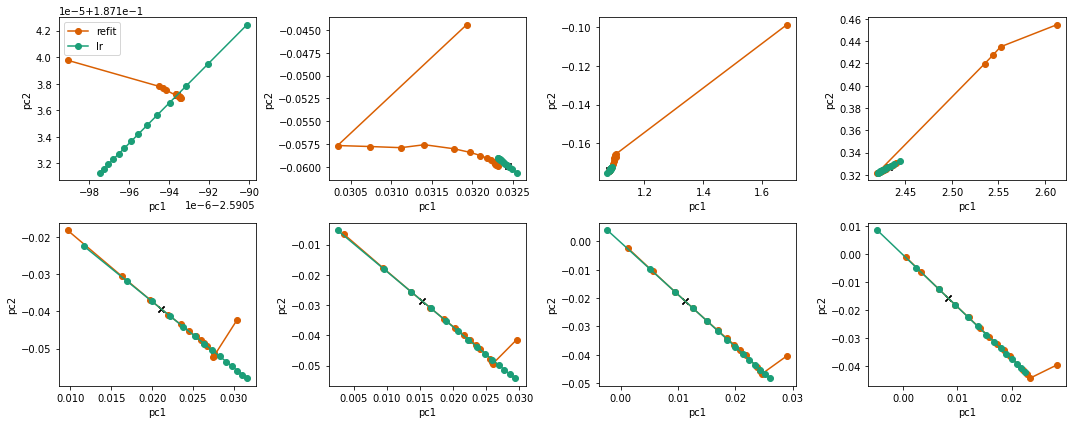

In [54]:
fig, axarr = plt.subplots(2, 4, figsize = (15, 6))

plot_centroids(refit_list, color = refit_color, label = 'refit')
plot_centroids(lr_list, color = lr_color, label = 'lr')

axarr[0, 0].legend()
fig.tight_layout()